This notebook reproduces the Lorentz results from [Champion et. al](https://www.pnas.org/doi/full/10.1073/pnas.1906995116). The data generation is specified in the  [appendix](https://www.pnas.org/action/downloadSupplement?doi=10.1073%2Fpnas.1906995116&file=pnas.1906995116.sapp.pdf) of [Champion et. al](https://www.pnas.org/doi/full/10.1073/pnas.1906995116), and is restated here. 


The data was syntheticaly generated using the governing lorentz
equations


$$
\begin{aligned}
\dot{z}_1 =& \sigma (z_2 - z_1) \\



\dot{z}_2 =& z_1 (\rho - z_3) - z_2 \\



\dot{z}_3 =& z_1 z_2 - \beta z_3 \\

\end{aligned}
$$

with the standard paramater values $\sigma = 10$, $\beta = \frac{8}{3}$ and $\rho = 28$

This data is then trnsformed using the first 6 legendre polynomials.


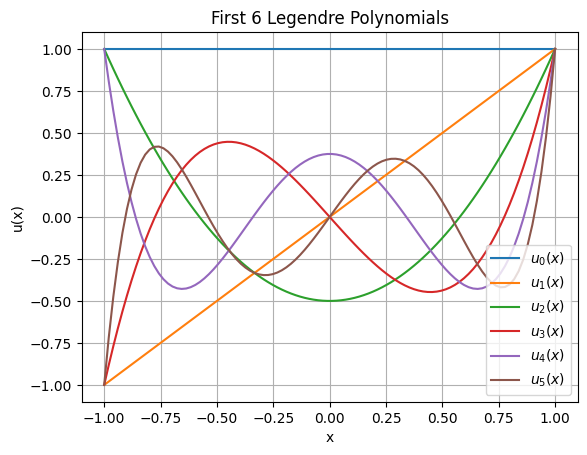

In [3]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.special import legendre

x = np.linspace(-1, 1, 128)

# Plot the first 6 Legendre polynomials
for n in range(6):
    u_n = legendre(n)
    y = u_n(x)
    # Plot the polynomial
    plt.plot(x, y, label=f'$u_{n}(x)$')


plt.xlabel('x')
plt.ylabel('u(x)')
plt.title('First 6 Legendre Polynomials')
plt.legend()
plt.grid(True)



Each datapoint $\boldsymbol{z} = [z_1, z_2, z_3]$ is mapped to a $\boldsymbol{x}$ by

$$
\boldsymbol{x}(t) = \boldsymbol{u_1} z_1(t) +  \boldsymbol{u_2}z_2(t) +  \boldsymbol{u_3}z_3(t) +  \boldsymbol{u_4}z_1(t)^3 +  \boldsymbol{u_5}z_2(t)^3 +  \boldsymbol{u_6} z_3(t)^3 
$$

Our $\boldsymbol{u}_n \in \mathbb{R}^{128}$ vectors correspond precisely to the ones depicted above; these are constructed by sampling the $n$-th Legendre polynomial at 128 equally spaced points within the interval $[-1, 1]$.

From the [appendix](https://www.pnas.org/action/downloadSupplement?doi=10.1073%2Fpnas.1906995116&file=pnas.1906995116.sapp.pdf) 
"To generate our data set, we simulate the system with 2048 initial conditions for the training set, 20 for the validation set, and 100 for the test set. For each initial condition we integrate the system forward in time from t = 0 to t = 5 with a spacing of ∆t = 0.02 to obtain 250 samples. Initial conditions 93 are chosen randomly from a uniform distribution over z1 ∈ [−36, 36], z2 ∈ [−48, 48], z3 ∈ [−16, 66]. This results in a training 94 set with 512,000 total samples"

The functions for generating such data is taken from [Kathleens github](https://github.com/kpchamp/SindyAutoencoders) and simply wrapped in some simple functions to create pytorch dataloaders.

In [ ]:
import sys
sys.path.append('../')
from lorentzTorchData import get_lorenz_data

# generate training, validation, testing data
noise_strength = 1e-6
training_data = get_lorenz_data(1024, noise_strength=noise_strength)
validation_data = get_lorenz_data(20, noise_strength=noise_strength)
testing_data = get_lorenz_data(20, noise_strength=noise_strength)



In [ ]:
sys.path.append('../../src')
from trainer import Trainer
from autoencoder import Encoder, Decoder, Autoencoder
from jax import random
import jax.numpy as jnp

# Define the encoder
key = random.PRNGKey(0)
input_dim = 128
latent_dim = 2
library_dim = 3
widths = [60, 40, 20]
#get example input from training_data loader
example_input = next(training_data)[0]

encoder = Encoder(input_dim, latent_dim, widths)
decoder = Decoder(input_dim, latent_dim, widths)


modelhyperparams = {'input_dim': input_dim, 'latent_dim': latent_dim, 'library_dim': library_dim, 'widths': widths, 'encoder': encoder, 'decoder': decoder}

trainer = Trainer(Autoencoder, modelhyperparams, key, training_data, validation_data, testing_data, noise_strength)